<h1 style="text-align: center; font-weight: bold;"><u>Import et chargement des données</u></h1>

In [18]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from scipy.stats import spearmanr

<h1 style="text-align: center; font-weight: bold;"><u>Étape 3 Modèle de clustering</u></h1>

In [19]:
# Chemin vers la base de données SQLite
db_path = 'data/olist.db'

# Créer une connexion à la base de données SQLite
conn = sqlite3.connect(db_path)

In [20]:
query = """
WITH max_date AS (
    SELECT MAX(order_purchase_timestamp) AS global_max_date
    FROM orders
),
customer_orders AS (
    SELECT 
        c.customer_unique_id,
        o.order_id,
        o.order_purchase_timestamp
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
),
payments AS (
    SELECT 
        co.customer_unique_id,
        MAX(co.order_purchase_timestamp) AS last_order_date,
        COUNT(DISTINCT co.order_id) AS frequency,
        SUM(op.payment_value) AS monetary
    FROM customer_orders co
    JOIN order_pymts op ON co.order_id = op.order_id
    GROUP BY co.customer_unique_id
),
rfm AS (
    SELECT 
        p.customer_unique_id,
        CAST(JULIANDAY(m.global_max_date) - JULIANDAY(p.last_order_date) AS INT) AS recency,
        p.frequency,
        ROUND(p.monetary, 2) AS monetary
    FROM payments p
    CROSS JOIN max_date m
)

SELECT *
FROM rfm
ORDER BY recency DESC;

"""
# Exécuter la requête et charger les résultats dans un DataFrame
df = pd.read_sql_query(query, conn)

In [21]:
rfm_features = df[['recency', 'frequency', 'monetary']]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

<h2 style="font-weight: bold;">3.A)<u>KMEANS</u></h2> 

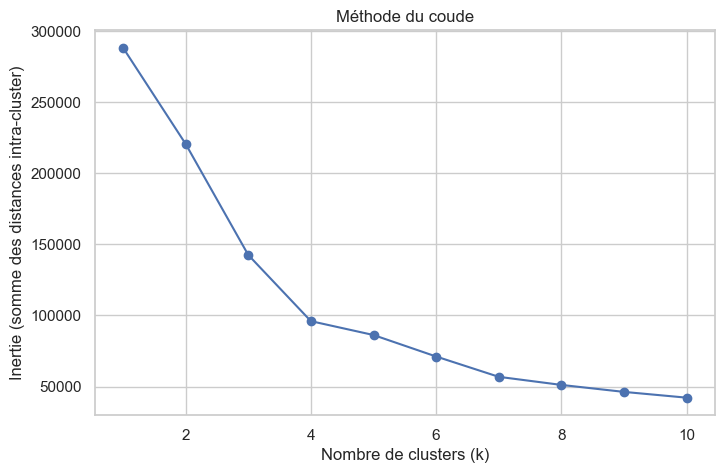

In [22]:
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie (somme des distances intra-cluster)')
plt.grid(True)
plt.show()

In [23]:
# KMeans avec k=4
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_scaled)

# Ajouter les labels au DataFrame original
df['kmeans_cluster'] = kmeans.labels_

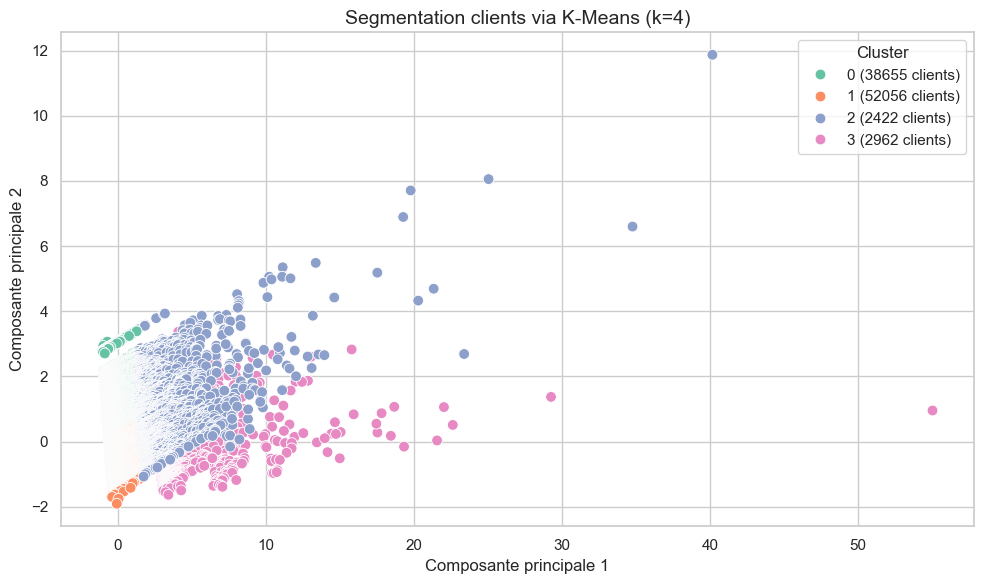

In [24]:
# Réduction à 2 dimensions pour la visualisation
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Ajout des colonnes PCA pour visualisation
df['PCA1'] = rfm_pca[:, 0]
df['PCA2'] = rfm_pca[:, 1]

# Compte des clients par cluster
cluster_counts = df['kmeans_cluster'].value_counts().sort_index()

# Filtrer les clusters avec 500 clients ou plus
large_clusters = cluster_counts[cluster_counts >= 500]

# Visualisation des clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='kmeans_cluster', palette='Set2', s=60)

# Ajout du titre et des labels
plt.title("Segmentation clients via K-Means (k=4)", fontsize=14)
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")

# Création des labels de la légende avec le nombre de clients
handles, labels = plt.gca().get_legend_handles_labels()

# Mise à jour des labels pour inclure le compte de clients
updated_labels = [f'{label} ({cluster_counts[int(label)]} clients)' if int(label) in large_clusters.index else label
                  for label in labels]

# Mise à jour de la légende
plt.legend(handles=handles, labels=updated_labels, title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
# Afficher les valeurs propres
print("Valeurs propres :", pca.explained_variance_)

# Et pourcentage de variance expliquée par PC1 et PC2
explained_ratio = pca.explained_variance_ratio_
print(f"Variance expliquée par PC1 : {explained_ratio[0]:.2%}")
print(f"Variance expliquée par PC2 : {explained_ratio[1]:.2%}")
print(f"Total PC1 + PC2 : {explained_ratio[:2].sum():.2%}")

Valeurs propres : [1.12914395 0.99874146]
Variance expliquée par PC1 : 37.64%
Variance expliquée par PC2 : 33.29%
Total PC1 + PC2 : 70.93%


C:\Users\david\AppData\Local\Temp\ipykernel_35248\711030219.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f'PC{i+1}' for i in range(len(explained_var))], y=explained_var, palette="viridis")


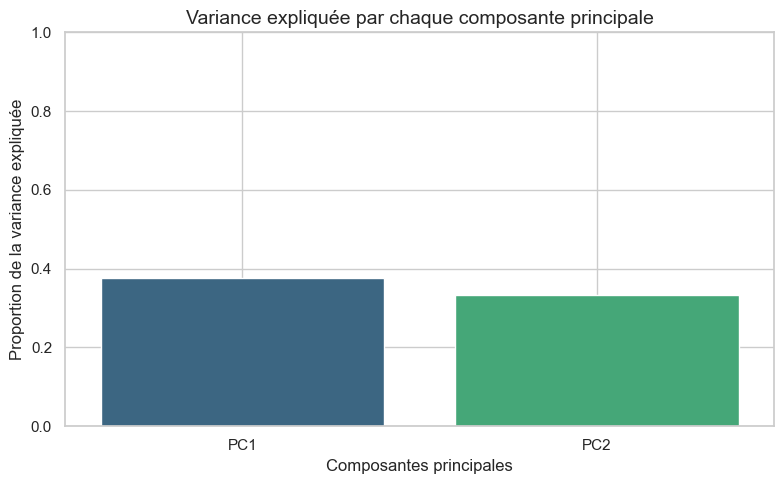

In [26]:
# Récupérer la variance expliquée
explained_var = pca.explained_variance_ratio_

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=[f'PC{i+1}' for i in range(len(explained_var))], y=explained_var, palette="viridis")
plt.title("Variance expliquée par chaque composante principale", fontsize=14)
plt.xlabel("Composantes principales")
plt.ylabel("Proportion de la variance expliquée")
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
df.groupby('kmeans_cluster')[['recency', 'frequency', 'monetary']].mean()

,recency,frequency,monetary
kmeans_cluster,,,
0,437.803699,1.000000,134.926653
1,177.361668,1.000000,135.164795
2,288.490091,1.015690,1196.225244
3,268.306212,2.116475,290.305945


| Cluster | Recency moyenne | Frequency moyenne | Monetary moyenne | Interprétation | Action recommandée |
|---------|------------------|-------------------|-------------------|----------------|---------------------|
| 0       | 438 jours        | 1.00              | 135 €             | 🟢 Clients à risque – anciens, peu fidèles, panier moyen bas | Relancer via des offres promotionnelles ou campagnes de réactivation |
| 1       | 177 jours        | 1.00              | 135 €             | 🟠 Clients récents mais peu fréquents – potentiels à fidéliser | Fidéliser rapidement avec des emails personnalisés ou avantages de bienvenue |
| 2       | 288 jours        | 1.02              | 1 196 €           | 🔵 Clients rentables – panier élevé mais peu réguliers | Proposer des produits premium, ventes privées, offres exclusives |
| 3       | 268 jours        | 2.12              | 290 €             | 🟣 Clients fidèles – achats réguliers avec panier correct | Récompenser la fidélité avec un programme adapté, offres personnalisées |


C:\Users\david\AppData\Local\Temp\ipykernel_35248\2122538322.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y='recency', data=df, ax=axes[0], palette='Set2')
C:\Users\david\AppData\Local\Temp\ipykernel_35248\2122538322.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y='frequency', data=df, ax=axes[1], palette='Set2')
C:\Users\david\AppData\Local\Temp\ipykernel_35248\2122538322.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y='monetary', data=df, ax=axes[2], palette='

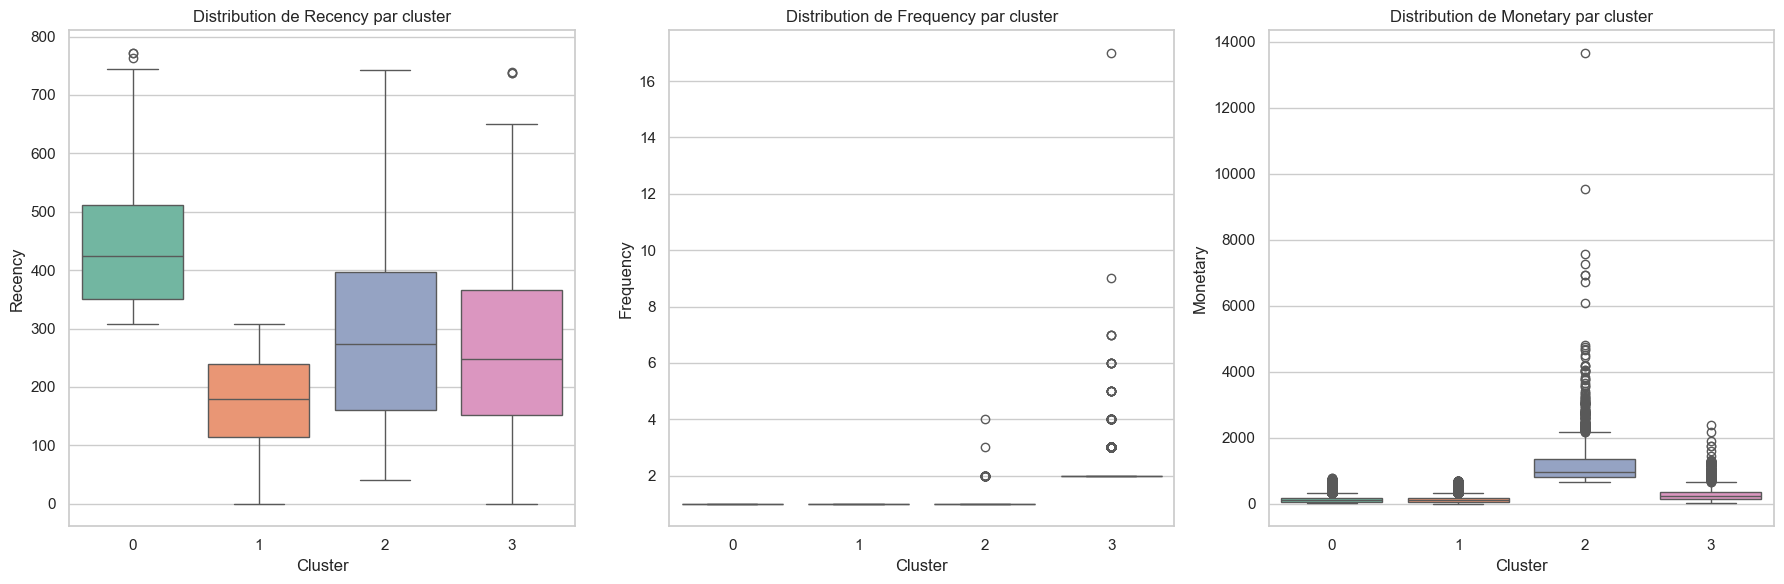

In [28]:
# Définir le style
sns.set(style="whitegrid")

# Créer les sous-graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Tracer les box plots
sns.boxplot(x='kmeans_cluster', y='recency', data=df, ax=axes[0], palette='Set2')
axes[0].set_title('Distribution de Recency par cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Recency')

sns.boxplot(x='kmeans_cluster', y='frequency', data=df, ax=axes[1], palette='Set2')
axes[1].set_title('Distribution de Frequency par cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Frequency')

sns.boxplot(x='kmeans_cluster', y='monetary', data=df, ax=axes[2], palette='Set2')
axes[2].set_title('Distribution de Monetary par cluster')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Monetary')

# Ajuster les espacements
plt.tight_layout()
plt.show()

C:\Users\david\AppData\Local\Temp\ipykernel_35248\1159729647.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y='recency_log', data=df_log, ax=axes[0], palette='Set2')
C:\Users\david\AppData\Local\Temp\ipykernel_35248\1159729647.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y='frequency_log', data=df_log, ax=axes[1], palette='Set2')
C:\Users\david\AppData\Local\Temp\ipykernel_35248\1159729647.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='kmeans_cluster', y='monetary_log', data=df_l

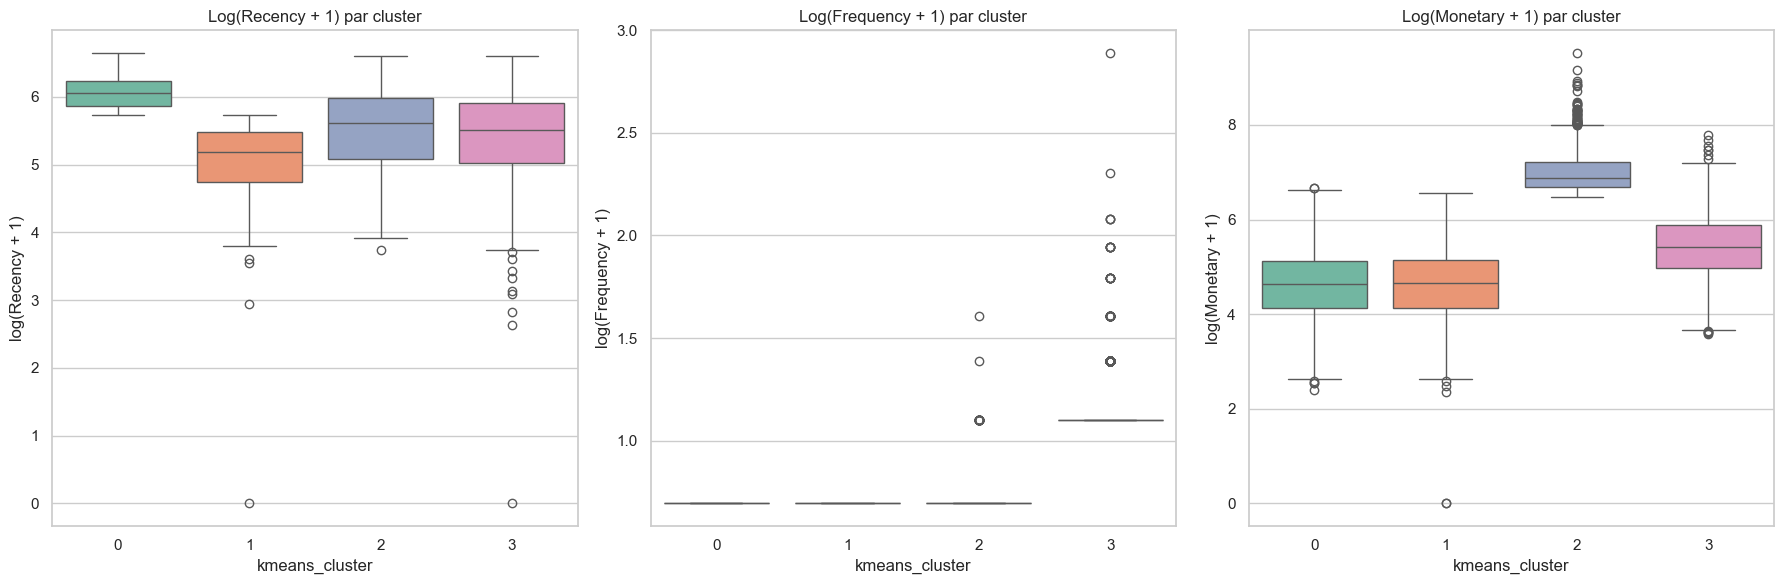

In [29]:
sns.set(style="whitegrid")

# Créer une copie transformée du DataFrame
df_log = df.copy()
df_log['recency_log'] = np.log1p(df_log['recency'])
df_log['frequency_log'] = np.log1p(df_log['frequency'])
df_log['monetary_log'] = np.log1p(df_log['monetary'])

# Tracer les box plots transformés
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='kmeans_cluster', y='recency_log', data=df_log, ax=axes[0], palette='Set2')
axes[0].set_title('Log(Recency + 1) par cluster')
axes[0].set_ylabel('log(Recency + 1)')

sns.boxplot(x='kmeans_cluster', y='frequency_log', data=df_log, ax=axes[1], palette='Set2')
axes[1].set_title('Log(Frequency + 1) par cluster')
axes[1].set_ylabel('log(Frequency + 1)')

sns.boxplot(x='kmeans_cluster', y='monetary_log', data=df_log, ax=axes[2], palette='Set2')
axes[2].set_title('Log(Monetary + 1) par cluster')
axes[2].set_ylabel('log(Monetary + 1)')

plt.tight_layout()
plt.show()

🟩 Cluster 0 – Clients à réactiver
Couleur : Vert

Récence moyenne : 438 jours → Clients très inactifs

Fréquence moyenne : 1 → Acheté une seule fois

Dépense moyenne : 135 R$ → Panier modéré

Profil : Ces clients n'ont pas commandé depuis très longtemps. Peu fidèles.

Action recommandée : Relancer avec des campagnes de réactivation, emails promotionnels, codes de réduction.

🟧 Cluster 1 – Nouveaux clients
Couleur : Orange

Récence moyenne : 177 jours → Clients récents

Fréquence moyenne : 1 → Acheté une seule fois

Dépense moyenne : 135 R$ → Panier modéré

Profil : Récents mais n'ont pas encore racheté. Possibles à fidéliser.

Action recommandée : Encourager un second achat (programme de bienvenue, suivi de commande, suggestions personnalisées).

🔵 Cluster 2 – Clients premium
Couleur : Bleu

Récence moyenne : 288 jours

Fréquence moyenne : 1.02 → Acheté une fois, voire deux

Dépense moyenne : 1 196 R$ → 💰 Très gros panier

Profil : Peu fréquents mais très rentables.

Action recommandée : Offres haut de gamme, ventes privées, produits premium.

🟣 Cluster 3 – Clients fidèles
Couleur : Violet

Récence moyenne : 268 jours

Fréquence moyenne : 2.1 → Achats répétés

Dépense moyenne : 290 R$ → Panier correct

Profil : Bon niveau de fidélité, clients réguliers.

Action recommandée : Fidélisation : récompenses, contenu personnalisé, programme fidélité.

<h2 style="font-weight: bold;">3.B)<u>DBSCAN</u></h2> 

In [30]:
# 1. Sélection des colonnes RFM
# rfm = df[['recency', 'frequency', 'monetary']].copy()

# 2. Normalisation des données
# scaler = StandardScaler()
# rfm_scaled = scaler.fit_transform(rfm)

# 3. Application de DBSCAN
dbscan = DBSCAN(eps=0.8, min_samples=5)  # Tu peux ajuster ces valeurs
clusters = dbscan.fit_predict(rfm_scaled)

# 4. Ajout des clusters au DataFrame
df['dbscan_cluster'] = clusters

# 5. Visualisation 2D avec Seaborn (ex: recency vs frequency)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df, x='recency', y='frequency',
    hue='dbscan_cluster', palette='Set2', s=60
)
plt.title("Segmentation client avec DBSCAN")
plt.legend(title="Cluster")
plt.show()

MemoryError: bad allocation

In [ ]:
df.groupby('dbscan_cluster')[['recency', 'frequency', 'monetary']].mean()

| Cluster | Interprétation possible                                                                 |
|---------|------------------------------------------------------------------------------------------|
| -1      | Outliers — clients atypiques avec de très hauts montants (2800€), peu nombreux, à analyser séparément. |
| 0       | Clients très basiques : 1 achat, panier moyen faible.                                   |
| 1       | Clients un peu plus fidèles (2 achats), panier moyen moyen.                             |
| 2       | Clients réguliers (3 achats), montant un peu plus élevé.                                |
| 3       | Clients très anciens (recency très élevée), mais très bons paniers. Clients dormants premium ? |
| 4       | Clients récents et très fidèles (4 achats), panier correct. Fidèles à choyer.           |
| 5       | Clients très récents, bons acheteurs, et bons paniers. Champions potentiels.            |


ValueError: Could not interpret value `dbscan_cluster` for `x`. An entry with this name does not appear in `data`.

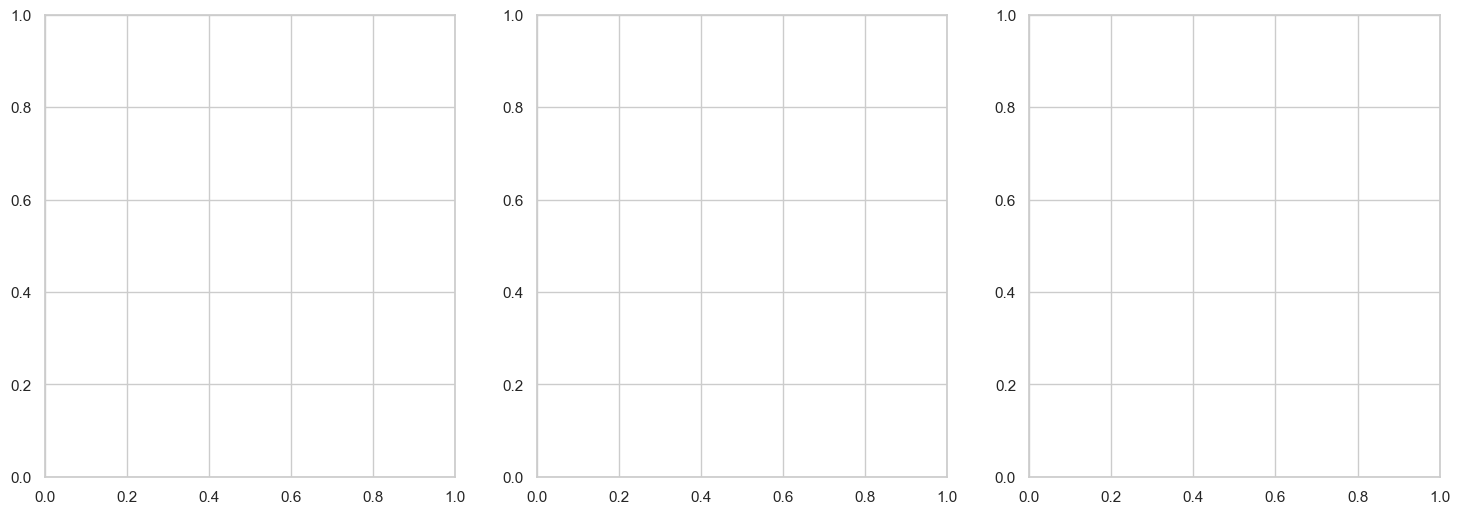

In [31]:
# Créer une figure avec 3 sous-graphiques côte à côte
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Liste des colonnes RFM
rfm_cols = ['recency', 'frequency', 'monetary']
titles = ['Recency', 'Frequency', 'Monetary']

# Boucle pour tracer chaque boxplot
for i, col in enumerate(rfm_cols):
    sns.boxplot(x='dbscan_cluster', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{titles[i]} par cluster DBSCAN')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(titles[i])

plt.tight_layout()
plt.show()

In [ ]:
# Création de colonnes transformées en log
df['recency_log'] = np.log1p(df['recency'])
df['frequency_log'] = np.log1p(df['frequency'])
df['monetary_log'] = np.log1p(df['monetary'])

# Tracer les boxplots avec les colonnes log-transformées
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

log_cols = ['recency_log', 'frequency_log', 'monetary_log']
titles = ['Recency (log)', 'Frequency (log)', 'Monetary (log)']

for i, col in enumerate(log_cols):
    sns.boxplot(x='dbscan_cluster', y=col, data=df, ax=axes[i])
    axes[i].set_title(f'{titles[i]} par cluster DBSCAN')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(titles[i])

plt.tight_layout()
plt.show()

## Fiches d'identité des groupes DBSCAN

| Cluster | Taille | Profil client                            | Recency (médiane) | Frequency (moyenne) | Monetary (moyenne) | Interprétation |
|---------|--------|------------------------------------------|-------------------|---------------------|--------------------|----------------|
| -1      | ?      | Clients atypiques, potentiellement VIP ou fraudeurs | 311.75           | 3.08               | 2803.09            | 🔍 **Outliers** à analyser : peu nombreux, mais dépensent énormément. Peuvent représenter des cas rares à choyer ou à surveiller. |
| 0       | ?      | Clients peu engagés                      | 288.31            | 1.00               | 160.26             | 💤 Clients très basiques : 1 seul achat avec un petit panier. Faible valeur. |
| 1       | ?      | Clients fidèles modérés                  | 269.98            | 2.00               | 281.56             | 😊 Clients avec 2 achats, panier moyen raisonnable. À fidéliser davantage. |
| 2       | ?      | Clients réguliers                        | 255.85            | 3.00               | 370.11             | 🔁 Bons clients réguliers, à conserver avec des offres adaptées. |
| 3       | ?      | Clients anciens mais à fort potentiel    | 554.43            | 1.00               | 3032.30            | 🕰️ Clients dormants premium : ont peu acheté mais ont un panier énorme. À réactiver. |
| 4       | ?      | Clients fidèles récents                  | 167.30            | 4.00               | 542.87             | 💎 Clients fidèles et récents. À choyer, fort potentiel de réachat. |
| 5       | ?      | Champions potentiels                     | 120.00            | 3.00               | 1313.40            | 👑 Clients très récents, bons acheteurs, à transformer en ambassadeurs. |


🟩 Cluster -1 – Clients atypiques / Outliers
Couleur : Vert foncé

Récence moyenne : 312 jours

Fréquence moyenne : 3

Dépense moyenne : 2 803 €

Profil : Clients rares mais très rentables. Atypiques par leur comportement. Possiblement VIP ou cas spéciaux.

Action recommandée :
🔍 Analyse individuelle. Si clients VIP : traitement personnalisé. Si suspicion de fraude ou incohérence : vérification manuelle.

🟧 Cluster 0 – Clients à réactiver
Couleur : Orange

Récence moyenne : 288 jours

Fréquence moyenne : 1

Dépense moyenne : 160 €

Profil : Clients peu engagés avec un seul achat, et inactifs depuis longtemps.

Action recommandée :
📣 Relancer avec des offres spéciales, des campagnes d’email marketing, ou des bons de réduction.

🟦 Cluster 1 – Clients réguliers mais modérés
Couleur : Bleu

Récence moyenne : 270 jours

Fréquence moyenne : 2

Dépense moyenne : 282 €

Profil : Clients fidèles de niveau moyen. Ils pourraient être fidélisés davantage.

Action recommandée :
📩 Proposer des programmes de fidélité, des ventes privées ou des recommandations ciblées.

🟪 Cluster 2 – Bons clients réguliers
Couleur : Violet

Récence moyenne : 256 jours

Fréquence moyenne : 3

Dépense moyenne : 370 €

Profil : Clients intéressants, revenus plusieurs fois avec un panier convenable.

Action recommandée :
🛍 Fidéliser davantage avec du contenu personnalisé, des invitations VIP ou des récompenses.

🟩 Cluster 3 – Clients dormants premium
Couleur : Vert clair

Récence moyenne : 554 jours

Fréquence moyenne : 1

Dépense moyenne : 3 032 €

Profil : Très anciens clients, peu actifs mais au panier très élevé.

Action recommandée :
🎯 Relancer avec des produits haut de gamme, des rappels personnalisés, ou des avantages exclusifs.

🟨 Cluster 4 – Clients fidèles récents
Couleur : Jaune

Récence moyenne : 167 jours

Fréquence moyenne : 4

Dépense moyenne : 543 €

Profil : Clients actifs, fidèles et récents.

Action recommandée :
💡 Renforcer le lien : offres VIP, programmes fidélité, remerciements personnalisés.

🟫 Cluster 5 – Champions potentiels
Couleur : Marron clair

Récence moyenne : 120 jours

Fréquence moyenne : 3

Dépense moyenne : 1 313 €

Profil : Clients récents et dépensiers. Très prometteurs.

Action recommandée :
👑 Mettre en avant : envoi d’offres exclusives, transformation en ambassadeurs de la marque.

In [34]:
# Fermer la connexion à la base de données
conn.close()